Imports

In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.8/898.8 kB 35.6 MB/s eta 0:00:00


In [2]:
import os
import shutil
import json
from ultralytics import YOLO
import random

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


Mount Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Directories

In [42]:
base_dir = "/content/drive/MyDrive/DLCV_Final_Project/Datasets/concats/"
output_dir = "/content/drive/MyDrive/DLCV/DLCV_Final_Project/Datasets/"
os.makedirs(output_dir, exist_ok=True)

# Perform YOLO

Get bounding boxes from YOLO and apply labels based on region of box

In [47]:
import os
import json
import shutil
import cv2

# Define image bounding boxes
bounding_boxes = {
    "two-breeds": [(0, 0, 224, 224), (224, 0, 448, 224)],
    "three-breeds": [(0, 0, 224, 224), (224, 0, 448, 224), (448, 0, 672, 224)],
    "four-breeds": [
        (0, 0, 224, 224),  # Top-left
        (224, 0, 448, 224),  # Top-right
        (0, 224, 224, 448),  # Bottom-left
        (224, 224, 448, 448),  # Bottom-right
    ],
}

# Perform YOLO inference
def detect_cats(image_path, model):
    results = model(image_path)
    detected_boxes = []
    for result in results:
        for box in result.boxes.data.tolist():
            x_min, y_min, x_max, y_max, conf, cls = box
            if int(cls) == 15:  # 'cat' class ID for COCO
                detected_boxes.append((x_min, y_min, x_max, y_max))  # Get bounding boxes for YOLO detected cats
    return detected_boxes

# Map YOLO detections to regions to get the correct labels
def map_YOLO_to_labels(detected_boxes, large_boxes, labels):
    labeled_detections = []
    used_regions = set()
    for box in detected_boxes:
        detected_x_min, detected_y_min, detected_x_max, detected_y_max = map(int, box)
        for i, (image_x_min, image_y_min, image_x_max, image_y_max) in enumerate(large_boxes):
            if (
                detected_x_min >= image_x_min and detected_y_min >= image_y_min
                and detected_x_max <= image_x_max and detected_y_max <= image_y_max
                and i not in used_regions
            ):
                labeled_detections.append({
                    "box": box,
                    "label": labels[i]
                })
                used_regions.add(i)
                break
    missed_count = len(labels) - len(labeled_detections)  # Count missed detections
    return labeled_detections, missed_count

def visualize_missed_detection(image_path, expected_boxes, detected_boxes, output_dir):
    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not found: {image_path}")

    # Draw ground truth boxes in green
    for box in expected_boxes:
        if len(box) == 4 and all(isinstance(coord, (int, float)) for coord in box):
            x_min, y_min, x_max, y_max = map(int, box)
            cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)  # Green for ground truth

    # Draw detected boxes in red
    for box in detected_boxes:
        if len(box) == 4 and all(isinstance(coord, (int, float)) for coord in box):
            x_min, y_min, x_max, y_max = map(int, box)
            cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 0, 255), 2)  # Red for YOLO detections

    # Save the image with bounding boxes
    save_path = os.path.join(output_dir, f"missed_{os.path.basename(image_path)}")
    cv2.imwrite(save_path, image)
    print(f"Saved visualization to {save_path}")


# Process all images and create a single yolo_detected_labels.json
def YOLO_process_dataset(base_dir, output_dir, model):
    yolo_results = {}
    missed_cats_file = os.path.join(output_dir, "missed_cats_detailed.txt")

    with open(missed_cats_file, "w") as missed_file:
        for folder_name, large_boxes in bounding_boxes.items():
            folder_path = os.path.join(base_dir, folder_name)
            json_path = os.path.join(folder_path, "labels.json")

            with open(json_path, "r") as f:
                metadata = json.load(f)

            for image_name, labels in metadata.items():
                new_image_name = f"{folder_name}_{image_name}"
                src_path = os.path.join(folder_path, image_name)
                dst_path = os.path.join(output_dir, new_image_name)
                shutil.copyfile(src_path, dst_path)

                detected_boxes = detect_cats(dst_path, model)
                labeled_detections, missed_count = map_YOLO_to_labels(detected_boxes, large_boxes, labels)

                if missed_count > 0:
                    missed_file.write(f"{new_image_name}: {missed_count} missed labels\n")
                    for i, label in enumerate(labels):
                        if i not in {detection['label'] for detection in labeled_detections}:
                            missed_file.write(f"Missed Breed: {label}\n")
                    missed_file.write(f"Expected Labels: {labels}\n")
                    missed_file.write(f"Detected Boxes: {detected_boxes}\n")
                    missed_file.write(f"Large Boxes: {large_boxes}\n")
                    missed_file.write("------------\n")

                    # Visualize missed detections
                    expected_boxes = [
                        (x_min, y_min, x_max, y_max)
                        for (x_min, y_min, x_max, y_max) in large_boxes
                    ]
                    visualize_missed_detection(dst_path, expected_boxes, detected_boxes, output_dir)

                yolo_results[new_image_name] = labeled_detections

    output_json_path = os.path.join(output_dir, "yolo_detected_labels_x.json")
    with open(output_json_path, "w") as f:
        json.dump(yolo_results, f, indent=4)

    print(f"YOLO processing complete. Results saved to {output_json_path}")
    print(f"Missed detections logged in {missed_cats_file}")

Initialize YOLO Model

In [48]:
# Initialize YOLO model
model = YOLO("yolov8n.pt")


Run YOLO inference and write results

In [49]:
folder_path = "/content/drive/MyDrive/DLCV_Final_Project/Datasets/concats/two-breeds"
print("Files in folder:", os.listdir(folder_path))


Files in folder: ['composite_2.jpg', 'composite_5.jpg', 'composite_11.jpg', 'composite_3.jpg', 'composite_8.jpg', 'composite_6.jpg', 'composite_9.jpg', 'composite_10.jpg', 'composite_7.jpg', 'composite_4.jpg', 'composite_14.jpg', 'composite_16.jpg', 'composite_17.jpg', 'composite_15.jpg', 'composite_12.jpg', 'composite_13.jpg', 'composite_18.jpg', 'composite_19.jpg', 'composite_20.jpg', 'composite_21.jpg', 'composite_23.jpg', 'composite_24.jpg', 'composite_22.jpg', 'composite_26.jpg', 'composite_25.jpg', 'composite_27.jpg', 'composite_29.jpg', 'composite_28.jpg', 'composite_31.jpg', 'composite_30.jpg', 'composite_33.jpg', 'composite_32.jpg', 'composite_34.jpg', 'composite_35.jpg', 'composite_39.jpg', 'composite_36.jpg', 'composite_37.jpg', 'composite_38.jpg', 'composite_40.jpg', 'composite_42.jpg', 'composite_41.jpg', 'composite_43.jpg', 'composite_45.jpg', 'composite_47.jpg', 'composite_44.jpg', 'composite_46.jpg', 'composite_48.jpg', 'composite_49.jpg', 'composite_50.jpg', 'composite

In [50]:
# Run the YOLO with data handling
YOLO_process_dataset(base_dir, output_dir, model)

Streaming output truncated to the last 5000 lines.
Speed: 2.1ms preprocess, 8.2ms inference, 1.2ms postprocess per image at shape (1, 3, 224, 640)

image 1/1 /content/drive/MyDrive/DLCV/DLCV_Final_Project/Datasets/three-breeds_composite_507.jpg: 224x640 3 cats, 10.2ms
Speed: 3.0ms preprocess, 10.2ms inference, 1.5ms postprocess per image at shape (1, 3, 224, 640)
Saved visualization to /content/drive/MyDrive/DLCV/DLCV_Final_Project/Datasets/missed_three-breeds_composite_507.jpg

image 1/1 /content/drive/MyDrive/DLCV/DLCV_Final_Project/Datasets/three-breeds_composite_508.jpg: 224x640 1 person, 3 cats, 8.7ms
Speed: 1.7ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 224, 640)

image 1/1 /content/drive/MyDrive/DLCV/DLCV_Final_Project/Datasets/three-breeds_composite_509.jpg: 224x640 2 cats, 1 dog, 4 bowls, 1 dining table, 8.2ms
Speed: 1.8ms preprocess, 8.2ms inference, 1.3ms postprocess per image at shape (1, 3, 224, 640)
Saved visualization to /content/drive/MyD

In [51]:
from collections import defaultdict

def count_missed_breeds(missed_file_path):
    breed_counts = defaultdict(int)

    with open(missed_file_path, "r") as f:
        lines = f.readlines()

    for line in lines:
        if line.startswith("Missed Breed:"):
            breed = line.split(":")[1].strip()
            breed_counts[breed] += 1

    return breed_counts

# Example Usage
missed_cats_file = os.path.join(output_dir, "missed_cats_detailed.txt")

missed_breed_counts = count_missed_breeds(missed_cats_file)

print("Missed Breeds Summary:")
for breed, count in missed_breed_counts.items():
    print(f"{breed}: {count}")


Missed Breeds Summary:
Maine Coon: 299
Tortoiseshell: 262
Bengal: 269
Persian: 327
Siamese: 315
Russian Blue: 284
Bombay: 282
Turkish Angora: 330
Calico: 244
Domestic Short Hair: 277


# Breed Classification

Imports

In [53]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
from PIL import Image

Split Training and Test data 80/20

In [54]:
# Paths for train and test data
all_concats_dir = "/content/drive/MyDrive/DLCV/DLCV_Final_Project/Datasets/all-concats"
labels_json_path = "/content/drive/MyDrive/DLCV/DLCV_Final_Project/Datasets/all-concats/yolo_detected_labels.json"
train_dir = "/content/drive/MyDrive/DLCV/DLCV_Final_Project/Datasets/all-concats/Datasets/train"
test_dir = "/content/drive/MyDrive/DLCV/DLCV_Final_Project/Datasets/all-concats/Datasets/test"
train_labels_path = "/content/drive/MyDrive/DLCV/DLCV_Final_Project/Datasets/train_labels.json"
test_labels_path = "/content/drive/MyDrive/DLCV/DLCV_Final_Project/Datasets/test_labels.json"

In [ ]:
# Create directories for training and testing data
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Load the labels
with open(labels_json_path, "r") as f:
    all_labels = json.load(f)

# List all images
all_images = list(all_labels.keys())

# Shuffle the images
random.shuffle(all_images)

# Split into 80/20 train-test split
split_index = int(0.8 * len(all_images))
train_images = all_images[:split_index]
test_images = all_images[split_index:]

# Create dictionaries for train and test labels
train_labels = {img: all_labels[img] for img in train_images}
test_labels = {img: all_labels[img] for img in test_images}

# Move images to their respective directories
for img in train_images:
    src = os.path.join(all_concats_dir, img)
    dst = os.path.join(train_dir, img)
    shutil.copyfile(src, dst)

for img in test_images:
    src = os.path.join(all_concats_dir, img)
    dst = os.path.join(test_dir, img)
    shutil.copyfile(src, dst)

# Save train and test labels
with open(train_labels_path, "w") as f:
    json.dump(train_labels, f, indent=4)

with open(test_labels_path, "w") as f:
    json.dump(test_labels, f, indent=4)

print("Data splitting complete.")
print(f"Training images: {len(train_images)}")
print(f"Testing images: {len(test_images)}")
print(f"Training labels saved to: {train_labels_path}")
print(f"Testing labels saved to: {test_labels_path}")


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/DLCV_Final_Project/Datasets/all-concats/yolo_detected_labels.json'

Breeds for classification

In [58]:
breeds = [
    "Domestic Short Hair", "Persian", "Bengal", "Siamese",
    "Calico", "Maine Coon", "Bombay", "Tortoiseshell", "Russian Blue", "Turkish Angora"
]

Data prep and transforms

In [55]:
class CatBreedsDataset(Dataset):
    def __init__(self, image_dir, labels_json, breeds, transform=None):
        self.image_dir = image_dir
        self.labels = json.load(open(labels_json, "r"))
        self.breeds = breeds
        self.transform = transform
        self.image_names = list(self.labels.keys())

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        image_path = os.path.join(self.image_dir, image_name)
        image = Image.open(image_path).convert("RGB")  # Load the image as a PIL object

        # Get bounding boxes and labels for the image
        detections = self.labels[image_name]
        boxes = [detection["box"] for detection in detections]
        labels = [self.breeds.index(detection["label"]) for detection in detections]

        # Crop and transform bounding box regions
        cropped_images = []
        cropped_labels = []
        for box, label in zip(boxes, labels):
            x_min, y_min, x_max, y_max = map(int, box)
            cropped_image = image.crop((x_min, y_min, x_max, y_max))  # Crop using PIL
            if self.transform:
                cropped_image = self.transform(cropped_image)  # Apply transformations (e.g., Resize)
            cropped_images.append(cropped_image)
            cropped_labels.append(label)

        return cropped_images, cropped_labels


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.05, hue=0.05),  # added to adjust colors
    # can add normalization, did not add for now
])

Load data for the model

In [ ]:
# Paths for train and test data
# all_concats_dir = "/content/drive/MyDrive/DLCV_Final_Project/Datasets/all-concats"
# labels_json_path = "/content/drive/MyDrive/DLCV_Final_Project/Datasets/all-concats/yolo_detected_labels.json"
# train_dir = "/content/drive/MyDrive/DLCV_Final_Project/Datasets/train"
# test_dir = "/content/drive/MyDrive/DLCV_Final_Project/Datasets/test"
# train_labels_path = "/content/drive/MyDrive/DLCV_Final_Project/Datasets/train_labels.json"
# test_labels_path = "/content/drive/MyDrive/DLCV_Final_Project/Datasets/test_labels.json"

In [56]:
# from torchvision.transforms import ToTensor

def custom_collate_fn(batch):

    all_cropped_images = []
    all_cropped_labels = []

    for cropped_images, cropped_labels in batch:
        all_cropped_images.extend(cropped_images)
        all_cropped_labels.extend(cropped_labels)

    # Stack all cropped regions and labels
    inputs = torch.stack(all_cropped_images, dim=0)
    targets = torch.tensor(all_cropped_labels)

    return inputs, targets

In [57]:
train_dataset = CatBreedsDataset(train_dir, train_labels_path, breeds, transform)
test_dataset = CatBreedsDataset(test_dir, test_labels_path, breeds, transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=custom_collate_fn)


NameError: name 'breeds' is not defined

# Data Visualization

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


In [ ]:
with open(device = torch.device("cuda" if torch.cuda.is_available() else "cpu"), 'r') as file:
    train_labels = json.load(file)


In [ ]:
def analyze_dataset_composition():
    compositions = {
        "two-breeds": 0,
        "three-breeds": 0,
        "four-breeds": 0
    }

    for image_name in train_labels.keys():
        prefix = image_name.split('_')[0]
        compositions[prefix] += 1

    # Plot composition
    plt.figure(figsize=(10, 6))
    plt.bar(compositions.keys(), compositions.values())
    plt.title('Distribution of Composite Images in Training Set')
    plt.ylabel('Number of Images')
    plt.show()

    print("Dataset Composition:")
    for k, v in compositions.items():
        print(f"{k}: {v} images")


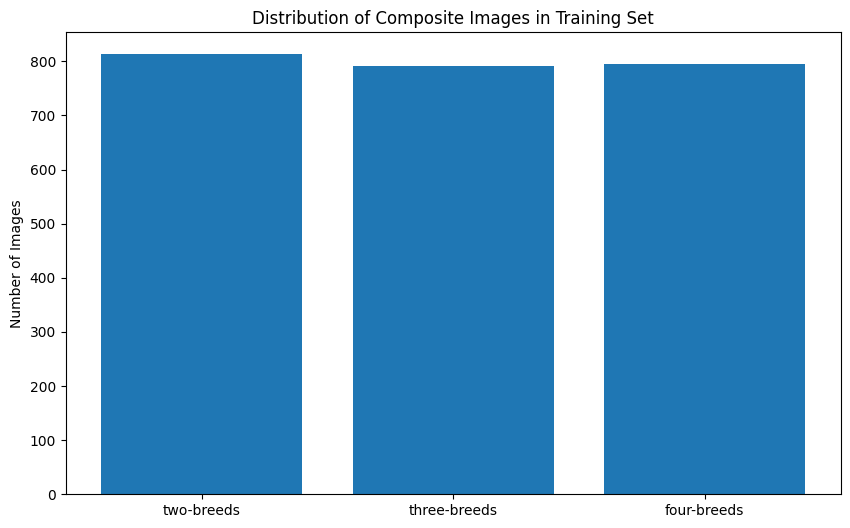

Dataset Composition:
two-breeds: 813 images
three-breeds: 792 images
four-breeds: 795 images


In [ ]:
analyze_dataset_composition()

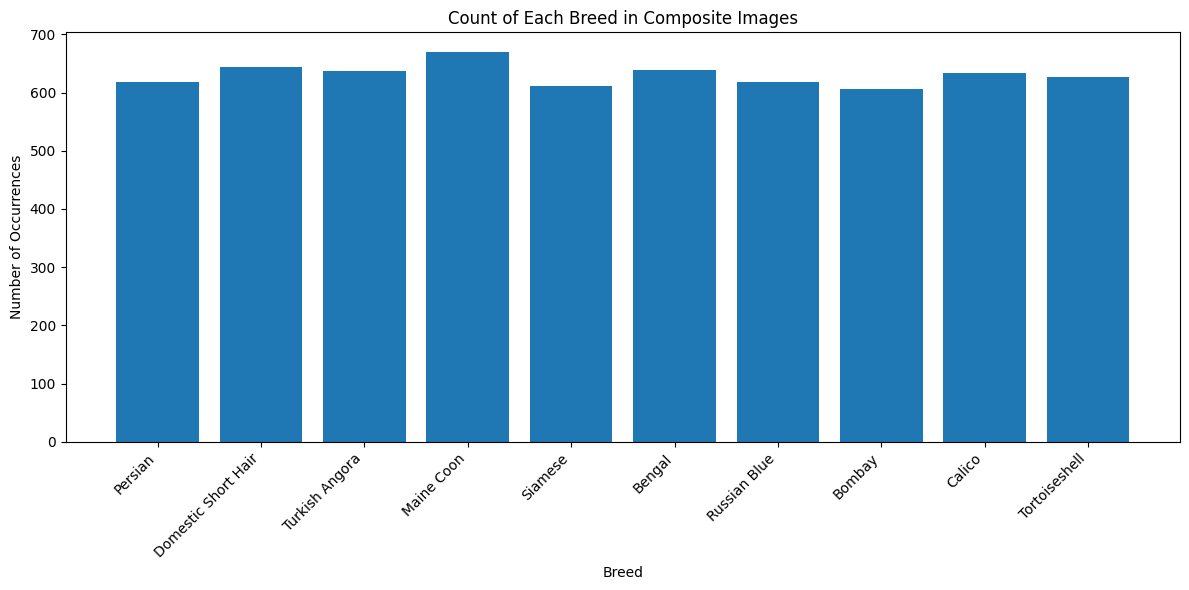

Breed Counts:
Persian: 618 occurrences
Domestic Short Hair: 644 occurrences
Turkish Angora: 637 occurrences
Maine Coon: 670 occurrences
Siamese: 611 occurrences
Bengal: 639 occurrences
Russian Blue: 619 occurrences
Bombay: 606 occurrences
Calico: 634 occurrences
Tortoiseshell: 626 occurrences


In [ ]:
def analyze_breed_counts():
    breed_counts = {}

    # Count the occurrences of each breed
    for image_data in train_labels.values():
        for entry in image_data:
            breed = entry["label"]
            if breed not in breed_counts:
                breed_counts[breed] = 0
            breed_counts[breed] += 1

    # Plot breed counts
    plt.figure(figsize=(12, 6))
    plt.bar(breed_counts.keys(), breed_counts.values())
    plt.xticks(rotation=45, ha='right')
    plt.title('Count of Each Breed in Composite Images')
    plt.ylabel('Number of Occurrences')
    plt.xlabel('Breed')
    plt.tight_layout()
    plt.show()

    # Print breed counts
    print("Breed Counts:")
    for breed, count in breed_counts.items():
        print(f"{breed}: {count} occurrences")

# Call the function
analyze_breed_counts()


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# for images, targets in train_loader:
#     print(images.shape)
#     print(targets)
#     break


RuntimeError: each element in list of batch should be of equal size

# Training with Resnet50

In [59]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [60]:
class CatBreedClassifier(nn.Module):
    def __init__(self, num_breeds):
        super(CatBreedClassifier, self).__init__()
        # Load pre-trained ResNet50
        self.resnet = models.resnet50(pretrained=True)

        # Freeze early layers
        for param in list(self.resnet.parameters())[:-6]:  # keep last 6 layers unfrozen
            param.requires_grad = False

        # Replace final fully connected layer
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),    # dropout from 0.3 -> 0.5
            nn.Linear(512, num_breeds)
        )

    def forward(self, x):
        return self.resnet(x)

In [61]:
def evaluate(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Forward pass
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)  # Get predicted classes
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    return correct / total if total > 0 else 0

In [62]:
def train_model(model, train_loader, test_loader, criterion, optimizer, device, num_epochs, model_save_path):
    best_accuracy = 0.0

    for epoch in range(num_epochs):

        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, targets in train_loader:  # Updated to match new DataLoader output
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

        train_accuracy = correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/total:.4f}, Accuracy: {train_accuracy:.4f}")

        # Evaluate on Test Set
        test_accuracy = evaluate(model, test_loader, device)
        print(f"Test Accuracy: {test_accuracy:.4f}")

        # Save the best model
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            torch.save(model.state_dict(), model_save_path)
            print(f"Model saved to {model_save_path}")

        # scheduler.step()

    print("Training complete.")

In [63]:
model = CatBreedClassifier(len(breeds)).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 188MB/s]


In [66]:
!pip install torchsummary


In [67]:
from torchsummary import summary
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.8)

# from torch.optim.lr_scheduler import StepLR

# scheduler = StepLR(optimizer, step_size=2, gamma=0.1)  # Reduce LR every 2 epochs

In [ ]:
# Define the model save path
model_save_path = "/content/drive/MyDrive/DLCV/DLCV_Final_Project/cat_breeds_resnet50.pth"

# Train the model
train_model(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=20,
    model_save_path=model_save_path
)

Epoch [1/20], Loss: 1.7824, Accuracy: 0.4327
Test Accuracy: 0.6401
Model saved to /content/drive/MyDrive/DLCV/DLCV_Final_Project/cat_breeds_resnet50.pth
Epoch [2/20], Loss: 1.1850, Accuracy: 0.6128
Test Accuracy: 0.6628
Model saved to /content/drive/MyDrive/DLCV/DLCV_Final_Project/cat_breeds_resnet50.pth
Epoch [3/20], Loss: 1.0639, Accuracy: 0.6566
Test Accuracy: 0.6677
Model saved to /content/drive/MyDrive/DLCV/DLCV_Final_Project/cat_breeds_resnet50.pth
Epoch [4/20], Loss: 1.0037, Accuracy: 0.6683
Test Accuracy: 0.6898
Model saved to /content/drive/MyDrive/DLCV/DLCV_Final_Project/cat_breeds_resnet50.pth
Epoch [5/20], Loss: 0.9619, Accuracy: 0.6824
Test Accuracy: 0.6941
Model saved to /content/drive/MyDrive/DLCV/DLCV_Final_Project/cat_breeds_resnet50.pth
Epoch [6/20], Loss: 0.9254, Accuracy: 0.6957
Test Accuracy: 0.6916
Epoch [7/20], Loss: 0.8859, Accuracy: 0.7080
Test Accuracy: 0.7014
Model saved to /content/drive/MyDrive/DLCV/DLCV_Final_Project/cat_breeds_resnet50.pth
Epoch [8/20], L

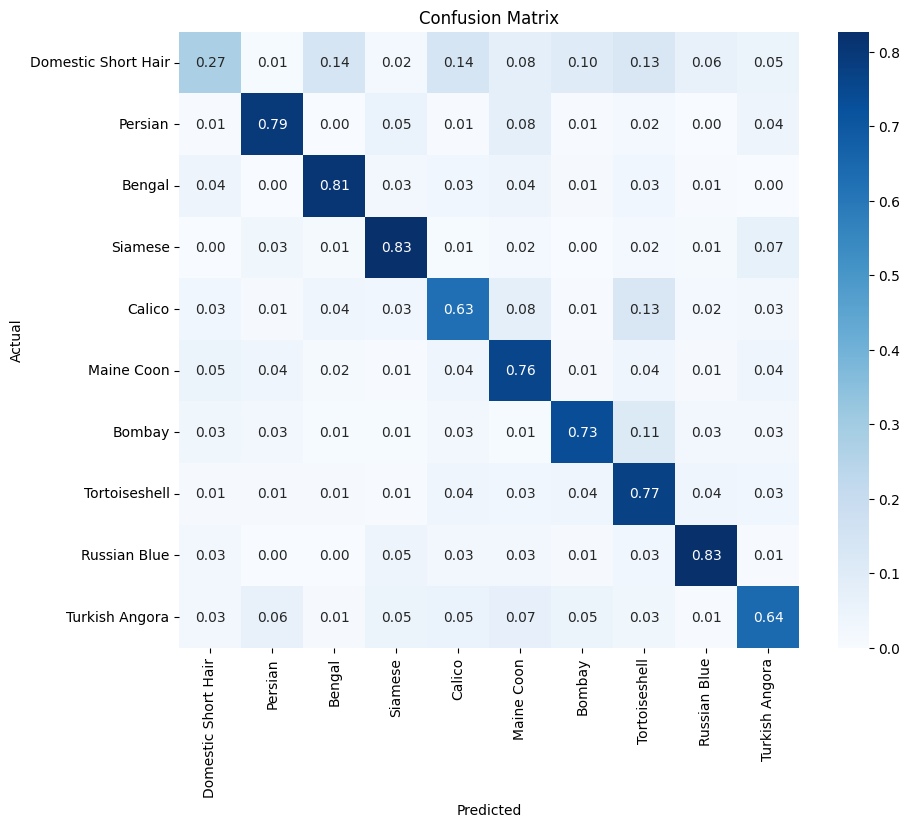

Classification Report:
                     precision    recall  f1-score   support

Domestic Short Hair       0.51      0.27      0.36       142
            Persian       0.82      0.79      0.80       182
             Bengal       0.78      0.81      0.79       159
            Siamese       0.76      0.83      0.79       150
             Calico       0.63      0.63      0.63       155
         Maine Coon       0.68      0.76      0.72       192
             Bombay       0.75      0.73      0.74       154
      Tortoiseshell       0.61      0.77      0.68       168
       Russian Blue       0.82      0.83      0.82       155
     Turkish Angora       0.70      0.64      0.67       174

           accuracy                           0.71      1631
          macro avg       0.70      0.71      0.70      1631
       weighted avg       0.71      0.71      0.70      1631



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(model, dataloader, device, class_names):
    # Set the model to evaluation mode
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Forward pass
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            # Collect predictions and true labels
            y_true.extend(targets.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Normalize confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Print classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))


plot_confusion_matrix(model, test_loader, device, breeds)

Adam Optimizer

In [ ]:
model2 = CatBreedClassifier(len(breeds)).to(device)

In [ ]:
criterion2 = nn.CrossEntropyLoss()
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)

In [ ]:
# Define the model save path
model2_save_path = "/content/drive/MyDrive/DLCV/DLCV_Final_Project/cat_breeds_resnet50_v2.pth"

# Train the model
train_model(
    model=model2,
    train_loader=train_loader,
    test_loader=test_loader,
    criterion=criterion2,
    optimizer=optimizer2,
    device=device,
    num_epochs=15,
    model_save_path=model2_save_path
)

Epoch [1/15], Loss: 1.3521, Accuracy: 0.5454
Test Accuracy: 0.6579
Model saved to /content/drive/MyDrive/DLCV/DLCV_Final_Project/cat_breeds_resnet50_v2.pth
Epoch [2/15], Loss: 1.0207, Accuracy: 0.6562
Test Accuracy: 0.6567
Epoch [3/15], Loss: 0.9388, Accuracy: 0.6926
Test Accuracy: 0.6511
Epoch [4/15], Loss: 0.8755, Accuracy: 0.7110
Test Accuracy: 0.6916
Model saved to /content/drive/MyDrive/DLCV/DLCV_Final_Project/cat_breeds_resnet50_v2.pth
Epoch [5/15], Loss: 0.8521, Accuracy: 0.7208
Test Accuracy: 0.6861
Epoch [6/15], Loss: 0.8047, Accuracy: 0.7313
Test Accuracy: 0.6800
Epoch [7/15], Loss: 0.7872, Accuracy: 0.7368
Test Accuracy: 0.6757
Epoch [8/15], Loss: 0.7558, Accuracy: 0.7435
Test Accuracy: 0.6910
Epoch [9/15], Loss: 0.7118, Accuracy: 0.7600
Test Accuracy: 0.6787
Epoch [10/15], Loss: 0.6993, Accuracy: 0.7673
Test Accuracy: 0.6996
Model saved to /content/drive/MyDrive/DLCV/DLCV_Final_Project/cat_breeds_resnet50_v2.pth
Epoch [11/15], Loss: 0.6820, Accuracy: 0.7695
Test Accuracy: 0

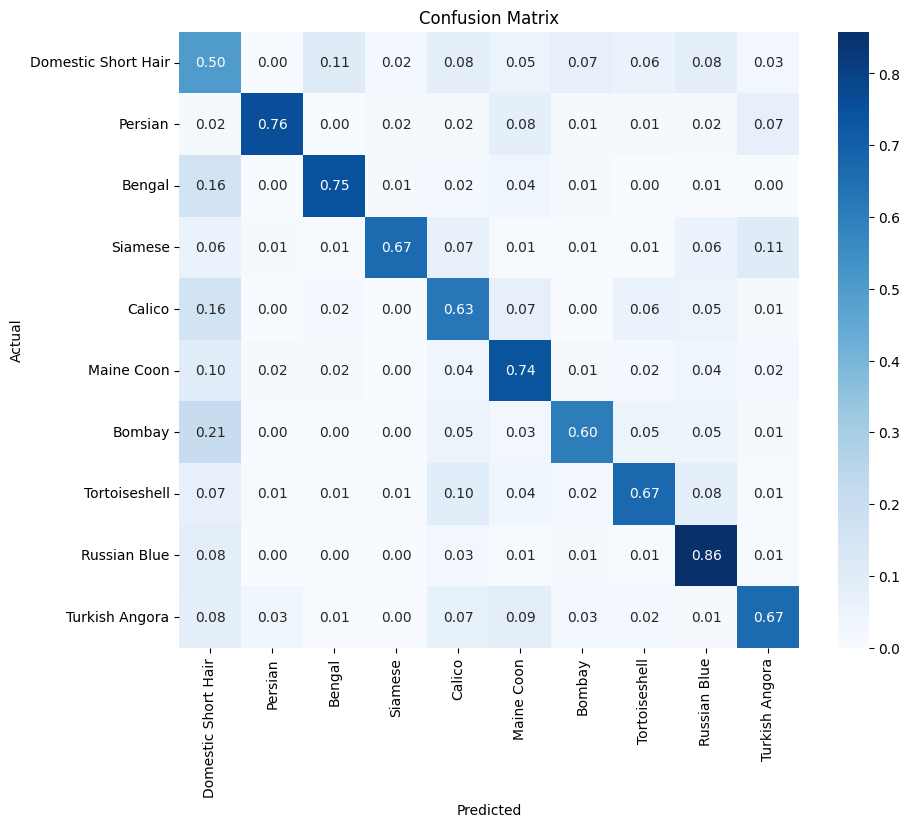

Classification Report:
                     precision    recall  f1-score   support

Domestic Short Hair       0.32      0.50      0.39       142
            Persian       0.92      0.76      0.83       182
             Bengal       0.83      0.75      0.79       159
            Siamese       0.92      0.67      0.77       150
             Calico       0.56      0.63      0.59       155
         Maine Coon       0.68      0.74      0.71       192
             Bombay       0.78      0.60      0.68       154
      Tortoiseshell       0.76      0.67      0.71       168
       Russian Blue       0.68      0.86      0.76       155
     Turkish Angora       0.73      0.67      0.70       174

           accuracy                           0.69      1631
          macro avg       0.72      0.68      0.69      1631
       weighted avg       0.72      0.69      0.70      1631



In [ ]:
plot_confusion_matrix(model2, test_loader, device, breeds)

# Training with ResNet18

In [52]:
class CatBreedClassifier18(nn.Module):
    def __init__(self, num_breeds):
        super(CatBreedClassifier18, self).__init__()
        # Load pre-trained ResNet18
        self.resnet = models.resnet18(pretrained=True)

        # Freeze early layers
        for param in list(self.resnet.parameters())[:-3]:  # keep last 3 layers unfrozen
            param.requires_grad = False

        # Replace final fully connected layer
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),    # dropout  0.3
            nn.Linear(512, num_breeds)
        )

    def forward(self, x):
        return self.resnet(x)

NameError: name 'nn' is not defined

In [ ]:
model3 = CatBreedClassifier18(len(breeds)).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 173MB/s]


In [ ]:
criterion3 = nn.CrossEntropyLoss()
optimizer3 = optim.Adam(model3.parameters(), lr=0.001)

In [ ]:
# Define the model save path
model3_save_path = "/content/drive/MyDrive/DLCV/DLCV_Final_Project/cat_breeds_resnet50_v2.pth"

# Train the model
train_model(
    model=model3,
    train_loader=train_loader,
    test_loader=test_loader,
    criterion=criterion3,
    optimizer=optimizer3,
    device=device,
    num_epochs=15,
    model_save_path=model2_save_path
)

Epoch [1/15], Loss: 1.5297, Accuracy: 0.4900
Test Accuracy: 0.6358
Model saved to /content/drive/MyDrive/DLCV/DLCV_Final_Project/cat_breeds_resnet50_v2.pth
Epoch [2/15], Loss: 1.1535, Accuracy: 0.6168
Test Accuracy: 0.6450
Model saved to /content/drive/MyDrive/DLCV/DLCV_Final_Project/cat_breeds_resnet50_v2.pth
Epoch [3/15], Loss: 1.0795, Accuracy: 0.6391
Test Accuracy: 0.6487
Model saved to /content/drive/MyDrive/DLCV/DLCV_Final_Project/cat_breeds_resnet50_v2.pth
Epoch [4/15], Loss: 1.0212, Accuracy: 0.6615
Test Accuracy: 0.6156
Epoch [5/15], Loss: 0.9791, Accuracy: 0.6680
Test Accuracy: 0.6370
Epoch [6/15], Loss: 0.9725, Accuracy: 0.6740
Test Accuracy: 0.6456
Epoch [7/15], Loss: 0.9339, Accuracy: 0.6816
Test Accuracy: 0.6499
Model saved to /content/drive/MyDrive/DLCV/DLCV_Final_Project/cat_breeds_resnet50_v2.pth
Epoch [8/15], Loss: 0.9282, Accuracy: 0.6886
Test Accuracy: 0.6652
Model saved to /content/drive/MyDrive/DLCV/DLCV_Final_Project/cat_breeds_resnet50_v2.pth
Epoch [9/15], Loss:

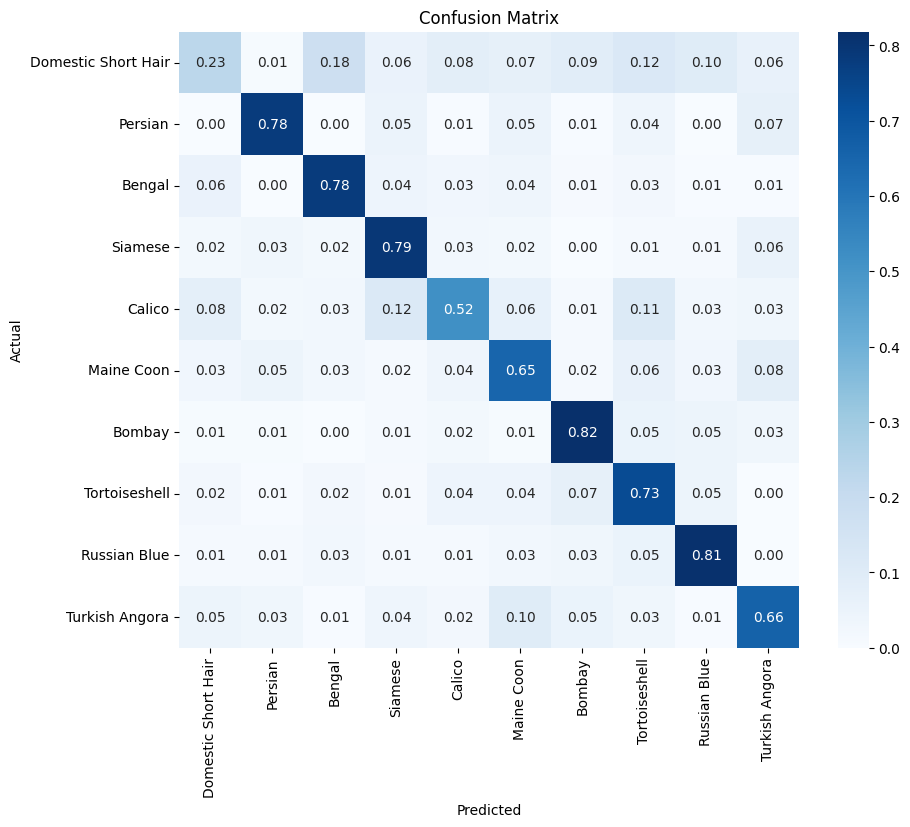

Classification Report:
                     precision    recall  f1-score   support

Domestic Short Hair       0.42      0.23      0.30       142
            Persian       0.84      0.78      0.81       182
             Bengal       0.73      0.78      0.75       159
            Siamese       0.67      0.79      0.73       150
             Calico       0.64      0.52      0.57       155
         Maine Coon       0.65      0.65      0.65       192
             Bombay       0.73      0.82      0.77       154
      Tortoiseshell       0.60      0.73      0.66       168
       Russian Blue       0.75      0.81      0.78       155
     Turkish Angora       0.66      0.66      0.66       174

           accuracy                           0.68      1631
          macro avg       0.67      0.68      0.67      1631
       weighted avg       0.67      0.68      0.67      1631



In [ ]:
plot_confusion_matrix(model3, test_loader, device, breeds)

# Train 3 models based on num breeds (unfinished)

In [ ]:
class CatBreedClassifier(nn.Module):
    def __init__(self, num_breeds):
        super(CatBreedClassifier, self).__init__()
        # Load pre-trained ResNet50
        self.resnet = models.resnet50(pretrained=True)

        # Freeze early layers
        for param in list(self.resnet.parameters())[:-4]:
            param.requires_grad = False

        # Replace final fully connected layer
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_breeds)
        )

    def forward(self, x):
        return self.resnet(x)


In [ ]:
model = CatBreedClassifier(num_breeds=len(breeds))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 150MB/s]


In [ ]:
# First, let's organize our data by number of breeds
class CatBreedsDataset(Dataset):
    def __init__(self, image_dir, labels_json, breeds, num_breeds, transform=None):
        self.image_dir = image_dir
        self.labels = json.load(open(labels_json, "r"))
        self.breeds = breeds
        self.transform = transform

        # Filter images based on number of breeds
        prefix = f"{num_breeds}-breeds"
        self.image_names = [img for img in self.labels.keys() if img.startswith(prefix)]

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        image_path = os.path.join(self.image_dir, image_name)
        image = Image.open(image_path).convert("RGB")

        detections = self.labels[image_name]
        boxes = [detection["box"] for detection in detections]
        labels = [self.breeds.index(detection["label"]) for detection in detections]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(boxes), torch.tensor(labels)



In [ ]:
# Create datasets for each number of breeds
def create_dataloaders(num_breeds):
    train_dataset = CatBreedsDataset(train_dir, train_labels_path, breeds, num_breeds, transform)
    test_dataset = CatBreedsDataset(test_dir, test_labels_path, breeds, num_breeds, transform)

    print(f"\n{num_breeds}-breeds dataset:")
    print(f"Training samples: {len(train_dataset)}")
    print(f"Test samples: {len(test_dataset)}")

    return (
        DataLoader(train_dataset, batch_size=32, shuffle=True),
        DataLoader(test_dataset, batch_size=32, shuffle=False)
    )



In [ ]:
# Create separate dataloaders for each type
two_breeds_loaders = create_dataloaders("two")
three_breeds_loaders = create_dataloaders("three")
four_breeds_loaders = create_dataloaders("four")



two-breeds dataset:
Training samples: 813
Test samples: 187

three-breeds dataset:
Training samples: 792
Test samples: 208

four-breeds dataset:
Training samples: 795
Test samples: 205


In [ ]:
# Training function for a specific number of breeds
def train_model_for_breeds(model, train_loader, test_loader, num_breeds, num_epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    best_acc = 0.0
    train_losses = []
    val_accuracies = []

    print(f"\nTraining {num_breeds}-breeds model:")

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, boxes, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        # Validation
        model.eval()
        correct = 0
        total = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for images, boxes, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)

                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        accuracy = 100 * correct / total
        val_accuracies.append(accuracy)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Loss: {epoch_loss:.4f}')
        print(f'Validation Accuracy: {accuracy:.2f}%')

        if accuracy > best_acc:
            best_acc = accuracy
            torch.save(model.state_dict(), f'best_model_{num_breeds}_breeds.pth')

    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=breeds, yticklabels=breeds)
    plt.title(f'Confusion Matrix - {num_breeds}-breeds')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return train_losses, val_accuracies


In [ ]:
# Train separate models for each number of breeds
models = {
    "two": CatBreedClassifier(len(breeds)).to(device),
    "three": CatBreedClassifier(len(breeds)).to(device),
    "four": CatBreedClassifier(len(breeds)).to(device)
}

results = {}
for num_breeds, (train_loader, test_loader) in [
    ("two", two_breeds_loaders),
    ("three", three_breeds_loaders),
    ("four", four_breeds_loaders)
]:
    print(f"\nTraining model for {num_breeds}-breeds images")
    losses, accuracies = train_model_for_breeds(
        models[num_breeds],
        train_loader,
        test_loader,
        num_breeds
    )
    results[num_breeds] = {"losses": losses, "accuracies": accuracies}

# Plot training results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

for num_breeds in ["two", "three", "four"]:
    ax1.plot(results[num_breeds]["losses"], label=f'{num_breeds}-breeds')
    ax2.plot(results[num_breeds]["accuracies"], label=f'{num_breeds}-breeds')

ax1.set_title('Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.set_title('Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()

plt.tight_layout()
plt.show()


Training model for two-breeds images

Training two-breeds model:


RuntimeError: stack expects each tensor to be equal size, but got [2, 4] at entry 0 and [1, 4] at entry 2